In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
%matplotlib inline

# 1.import data

In [2]:
#dataの読み込み
data = pd.read_csv(r'C:\Users\User\Downloads\kaggle\heart attack\heart.csv')

In [3]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# 2.preprocessing

In [4]:
#大きさとは関係ない値をonehotに変える
onehot_list = ['cp','restecg','slope','ca','thal']
data_onehot_list = data[onehot_list]
data_rest = data.drop(onehot_list,axis=1)

In [5]:
#onehot columnnに名付け
column_name = [['cp{}'.format(i) for i in range(data.cp.max()+1)],
               ['restecg{}'.format(i) for i in range(data.restecg.max()+1)],
               ['slope{}'.format(i) for i in range(data.slope.max()+1)],
               ['ca{}'.format(i) for i in range(data.ca.max()+1)],
               ['thal{}'.format(i) for i in range(data.thal.max()+1)]]
column_name = np.concatenate(column_name)
data_onehot = pd.DataFrame(OneHotEncoder().fit_transform(data_onehot_list).toarray(),columns=column_name)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [7]:
#列をくっつけあう
datax = data_rest.drop('target',axis=1)
datay = data_rest.target
datax2 = pd.concat([datax,data_onehot],axis=1)

In [36]:
#test/trainに分ける
x_train,x_test,y_train,y_test = train_test_split(datax2,datay,test_size=0.3,random_state=0)

# 3.create model

In [193]:
#gridsearchとpipline同時に使えないので、gridを作る
x=np.arange(30,60)
y=np.arange(20,40)
X,Y = np.meshgrid(x,y)
X=np.concatenate(X)
Y=np.concatenate(Y)

In [213]:
#try and error:
for i,j in zip(X,Y):
    pl = Pipeline([('st',StandardScaler()),
                    ('pca',PCA(n_components=0.99)),
                    ('rf',RandomForestClassifier(n_estimators=i,max_depth=j))]
        )
    pl.fit(x_train,y_train)
    score = pl.score(x_test,y_test)
    if score > 0.88:
        print('n_estimator:{} , max_depth:{} , accuracy:{}'.format(i,j,score))
        break

n_estimator:36 , max_depth:24 , accuracy:0.8901098901098901


In [214]:
pl.score(x_test,y_test)

0.8901098901098901

# 4.metrics

In [268]:
def scorer(x,y,classifier):
    y_predict = np.array(classifier.predict(x))
    #判断標準
    matrix = confusion_matrix(y,y_predict).T
    accuracy = np.round((matrix[1,1]+matrix[0,0])/(matrix.sum()),3)
    precision = np.round(matrix[1,1]/(matrix[1,1]+matrix[1,0]),3)
    recall = np.round(matrix[1,1]/(matrix[1,1]+matrix[0,1]),3)
    f1 = np.round(2/(1/precision+1/recall),3)
    print('accuracy:[{}] , precision:[{}] , recall:[{}] , f1:[{}]'.format(accuracy,precision,recall,f1))
    #図の作成
    sns.heatmap(matrix,cmap='Blues',annot=True)
    plt.xlabel('actual');plt.ylabel('predict')
    plt.title('confusion_matrix')

In [330]:
def roc_maker(x,y,classifier):
    #ROCの計算
    y_predict = np.array(classifier.predict(x))
    matrix = confusion_matrix(y,y_predict).T
    TPR_select = matrix[1,1]/(matrix[1,1]+matrix[0,1])
    FPR_select = matrix[1,0]/(matrix[1,0]+matrix[0,0])
    FPR_list = []
    TPR_list = []
    df = pd.DataFrame(classifier.predict_proba(x))
    for i in np.linspace(0,1,1000):
        def threshold(a):
            if a >= i:
                return 1
            else:
                return 0
        df[2] = df[1].apply(threshold)
        roc_matrix = confusion_matrix(y,df[2].values).T
        TPR = roc_matrix[1,1]/(roc_matrix[1,1]+roc_matrix[0,1])
        FPR = roc_matrix[1,0]/(roc_matrix[1,0]+roc_matrix[0,0])
        FPR_list.append(FPR)
        TPR_list.append(TPR)
    #AUCの計算
    AUC = np.round(np.absolute(np.trapz(TPR_list,FPR_list,axis=0)),3)
    print('AUC of classifier is : {}'.format(AUC))
    #図の作成
    plt.plot(FPR_list,TPR_list)
    plt.scatter(FPR_select,TPR_select,color='r')
    plt.xlim(-0.01,1);plt.ylim(0,1)
    plt.xlabel('FPR');plt.ylabel('TPR')
    plt.grid()
    plt.title('ROC curve')

accuracy:[0.89] , precision:[0.878] , recall:[0.915] , f1:[0.896]


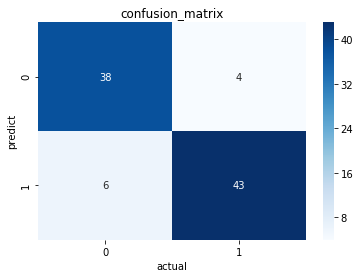

In [269]:
scorer(x_test,y_test,pl)

AUC of classifier is : 0.917


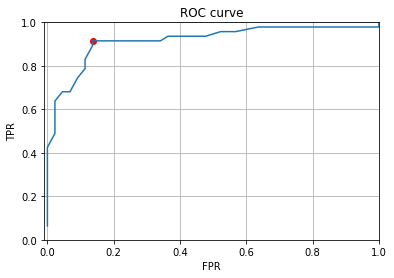

In [331]:
roc_maker(x_test,y_test,pl)

# 5.importance

In [13]:
importance = pd.Series(data=grid.best_estimator_.feature_importances_,index=datax2.columns)
importance.sort_values(ascending=False,inplace=True)

Text(0.5, 1.0, 'importance')

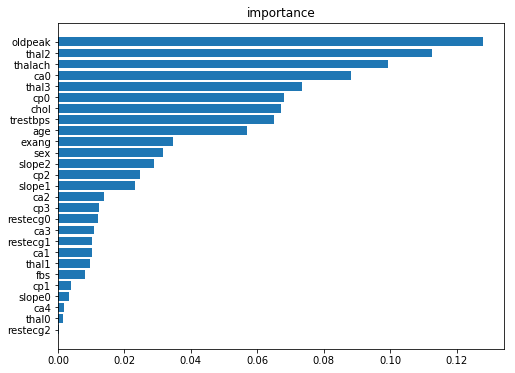

In [27]:
plt.figure(figsize=(8,6))
plt.barh(importance.index,importance.values)
plt.gca().invert_yaxis()
plt.title('importance')